# Hello Image Segmentation

A very basic introduction to using segmentation models with OpenVINO™.

In this tutorial, a pre-trained [road-segmentation-adas-0001](https://docs.openvino.ai/2023.0/omz_models_model_road_segmentation_adas_0001.html) model from the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used. ADAS stands for Advanced Driver Assistance Services. The model recognizes four classes: background, road, curb and mark.

#### Table of content:
- [Imports](#Imports-Uparrow)
- [Download model weights](#Download-model-weights-Uparrow)
- [Select inference device](#Select-inference-device-Uparrow)
- [Load the Model](#Load-the-Model-Uparrow)
- [Load an Image](#Load-an-Image-Uparrow)
- [Do Inference](#Do-Inference-Uparrow)
- [Prepare Data for Visualization](#Prepare-Data-for-Visualization-Uparrow)
- [Visualize data](#Visualize-data-Uparrow)


In [1]:
# Install openvino package
%pip install -q "openvino>=2023.1.0"

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\rohan\anaconda3\envs\openvino_env\python.exe -m pip install --upgrade pip' command.


## Imports [$\Uparrow$](#Table-of-content:)


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

from notebook_utils import segmentation_map_to_image, download_file

## Download model weights [$\Uparrow$](#Table-of-content:)


In [3]:
from pathlib import Path

base_model_dir = Path("./model").expanduser()

model_name = "road-segmentation-adas-0001"
model_xml_name = f'{model_name}.xml'
model_bin_name = f'{model_name}.bin'

model_xml_path = base_model_dir / model_xml_name

if not model_xml_path.exists():
    model_xml_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.xml"
    model_bin_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.bin"

    download_file(model_xml_url, model_xml_name, base_model_dir)
    download_file(model_bin_url, model_bin_name, base_model_dir)
else:
    print(f'{model_name} already downloaded to {base_model_dir}')

model\road-segmentation-adas-0001.xml:   0%|          | 0.00/389k [00:00<?, ?B/s]

model\road-segmentation-adas-0001.bin:   0%|          | 0.00/720k [00:00<?, ?B/s]

## Select inference device [$\Uparrow$](#Table-of-content:)

select device from dropdown list for running inference using OpenVINO

In [4]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

## Load the Model [$\Uparrow$](#Table-of-content:)


In [5]:
core = ov.Core()

model = core.read_model(model=model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output(0)

## Load an Image [$\Uparrow$](#Table-of-content:)
A sample image from the [Mapillary Vistas](https://www.mapillary.com/dataset/vistas) dataset is provided. 

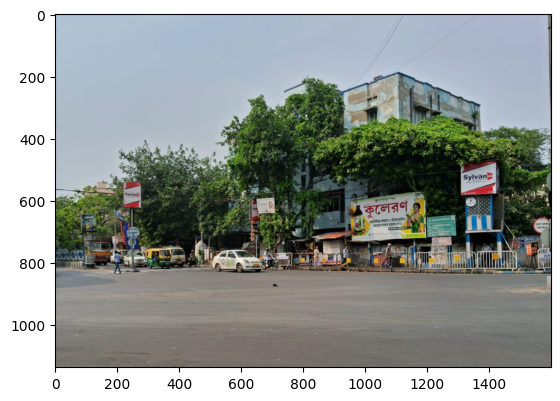

In [19]:
# Download the image from the openvino_notebooks storage
"""image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/empty_road_mapillary.jpg",
    directory="data"
)

# The segmentation network expects images in BGR format.
image = cv2.imread(str(image_filename))"""

image = cv2.imread("jadavpur.jpg")

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer_ir.shape

# OpenCV resize expects the destination size as (width, height).
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(
    resized_image.transpose(2, 0, 1), 0
)  
plt.imshow(rgb_image)

## Do Inference [$\Uparrow$](#Table-of-content:)


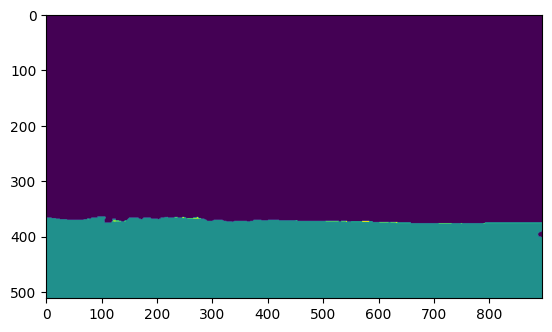

In [20]:
# Run the inference.
result = compiled_model([input_image])[output_layer_ir]

# Prepare data for visualization.
segmentation_mask = np.argmax(result, axis=1)
plt.imshow(segmentation_mask.transpose(1, 2, 0))

## Prepare Data for Visualization [$\Uparrow$](#Table-of-content:)


In [21]:
# Define colormap, each color represents a class.
colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52]])

# Define the transparency of the segmentation mask on the photo.
alpha = 0.3

# Use function from notebook_utils.py to transform mask to an RGB image.
mask = segmentation_map_to_image(segmentation_mask, colormap)
resized_mask = cv2.resize(mask, (image_w, image_h))

# Create an image with mask.
image_with_mask = cv2.addWeighted(resized_mask, alpha, rgb_image, 1 - alpha, 0)

## Visualize data [$\Uparrow$](#Table-of-content:)


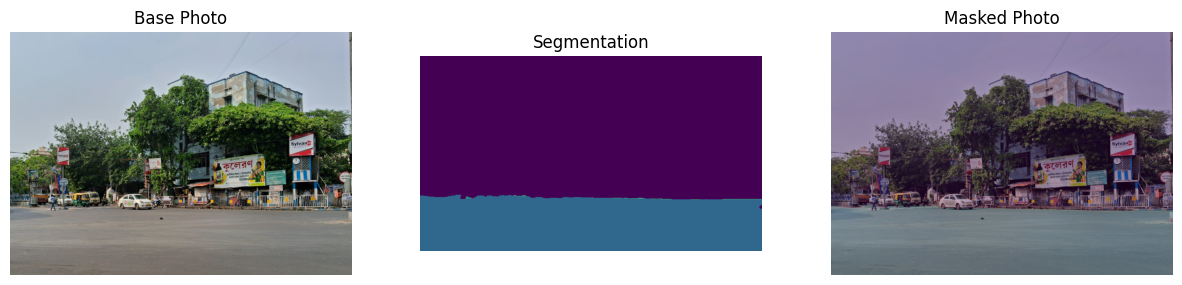

In [18]:
# Define titles with images.
data = {"Base Photo": rgb_image, "Segmentation": mask, "Masked Photo": image_with_mask}

# Create a subplot to visualize images.
fig, axs = plt.subplots(1, len(data.items()), figsize=(15, 10))

# Fill the subplot.
for ax, (name, image) in zip(axs, data.items()):
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)

# Display an image.
plt.show(fig)